### softmax(), sigmoid() 함수 <hr>
- sigmoid() : y=wx+b 결과    1개 전달 => 반환 : 0.0 ~ 1.0 사이 값으로 변환
- softmax() : y=wx+b 결과 여러개 전달 => 반환 : 여러개의 결과값의 합이 1.0이 되도록 변환 => 다중분류

In [1]:
# 모듈 로딩
import torch                        # PyTorch 기본 모듈 (텐서 및 기본 함수들)
import torch.nn.functional as F     # PyTorch 인공신경망 관련 함수들

In [2]:
# 임의 데이터 생성
data1 = torch.tensor([1, 2, 1, 1, 2])
data1.shape

torch.Size([5])

In [3]:
F.sigmoid(data1)

tensor([0.7311, 0.8808, 0.7311, 0.7311, 0.8808])

In [4]:
data1.unsqueeze_(dim=1)
data1.shape

torch.Size([5, 1])

In [5]:
input = torch.rand(2, 3)
output = F.softmax(input)
output.sum(dim=1)

C:\Users\kdp\AppData\Local\Temp\ipykernel_17528\3182668218.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.softmax(input)


tensor([1., 1.])

In [6]:
output.max(dim=1)[1][0].item()

2

In [7]:
output.argmax(dim=1)

tensor([2, 1])

[5] 번 문제 풀이

(1) 모듈 로딩 및 데이터 준비

In [8]:
# 모듈 로딩
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np

import torch
import torch.nn as nn               # LinearRegression 기능의 클래스 Linear
import torch.nn.functional as F     # 손실함수
import torch.optim as optim     # 경사하강법 기반의 최적화 관련 모듈

In [9]:
# 데이터 준비
fashion_db = 'fashion-mnist'

fashion_data = fetch_openml(name=fashion_db, parser='auto') #, as_frame=False)

In [10]:
feature = fashion_data['data']
target = fashion_data['target']

In [11]:
# 피처와 타겟 개수 확인
print(f'feature => {feature.shape}, {feature.ndim}D')
print(f'target => {target.shape}, {target.ndim}D')

feature => (70000, 784), 2D
target => (70000,), 1D


In [12]:
# 분류 확인
print(f'feature name => {fashion_data["feature_names"]}')
print(f'target name => {fashion_data["target_names"]}')
print(f'categories => {fashion_data["categories"]}')
print(f'categories -> {target.unique()}')

feature name => ['pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7', 'pixel8', 'pixel9', 'pixel10', 'pixel11', 'pixel12', 'pixel13', 'pixel14', 'pixel15', 'pixel16', 'pixel17', 'pixel18', 'pixel19', 'pixel20', 'pixel21', 'pixel22', 'pixel23', 'pixel24', 'pixel25', 'pixel26', 'pixel27', 'pixel28', 'pixel29', 'pixel30', 'pixel31', 'pixel32', 'pixel33', 'pixel34', 'pixel35', 'pixel36', 'pixel37', 'pixel38', 'pixel39', 'pixel40', 'pixel41', 'pixel42', 'pixel43', 'pixel44', 'pixel45', 'pixel46', 'pixel47', 'pixel48', 'pixel49', 'pixel50', 'pixel51', 'pixel52', 'pixel53', 'pixel54', 'pixel55', 'pixel56', 'pixel57', 'pixel58', 'pixel59', 'pixel60', 'pixel61', 'pixel62', 'pixel63', 'pixel64', 'pixel65', 'pixel66', 'pixel67', 'pixel68', 'pixel69', 'pixel70', 'pixel71', 'pixel72', 'pixel73', 'pixel74', 'pixel75', 'pixel76', 'pixel77', 'pixel78', 'pixel79', 'pixel80', 'pixel81', 'pixel82', 'pixel83', 'pixel84', 'pixel85', 'pixel86', 'pixel87', 'pixel88', 'pixel89', 'pixel90', 'p

(2) 데이터 가공 및 전처리 <hr>
- 결측치/중복/이상치 => 없음
- 다중분류 => 2진분류 변환 : target 변환
- 표준화 => 이미지 처리 (동일 크기 및 색상채널) : 동일크기(28x28)와 채널(흑백 1)
- 정규화 => 피처 정규화 / 타겟 정규화

In [13]:
## => [2-1] 다중분류 => 2진분류 (변환 : target 변환)
target = target == '0'
target.unique()

array([False,  True])

In [14]:
## => [2-2] 정규화 => 피처 : 784개는 색상값 (0 ~ 255 범위 값)
norm_feature = feature / 255.
norm_feature.head(2)

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.003922,0.0,0.0,0.0,0.0,...,0.466667,0.447059,0.509804,0.298039,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
## => [2-2] 정규화 => 타겟 : One-Hot-Encoding 으로 변환
pd.get_dummies(target)      # DataFrame 에서 바로 생성

,False,True
0,True,False
1,False,True
2,False,True
3,True,False
4,False,True
...,...,...
69995,True,False
69996,True,False
69997,True,False
69998,True,False


In [16]:
type(target), target.shape, target.ndim

(pandas.core.series.Series, (70000,), 1)

In [17]:
targetDF = target.to_frame()    # Series(1차원)를 DataFrame(2차원)으로 변환
print(targetDF.shape, targetDF.ndim)

(70000, 1) 2


In [18]:
from sklearn.preprocessing import OneHotEncoder

ohEncoder = OneHotEncoder(sparse_output=False)      # sparse_output=False : transform() 반환값 => ndarray
ohEncoder.fit(targetDF)                             # 2차원 데이터를 넘겨줘야 함
ohEncoder.categories_                               # 0번째 컬럼의 값이 1이면 타겟 값이 False, 1번째 컬럼의 값이 1이면 타겟 값이 True

[array([False,  True])]

In [19]:
norm_target = ohEncoder.transform(targetDF)         # One-Hot-Encoding 적용한 y값 (numpy.ndarray)
norm_target.shape, norm_target.ndim

((70000, 2), 2)

In [22]:
norm_target[:5]

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.]])

(3) 학습 준비 <hr>
- 데이터셋 준비 : 텐서화 & (훈련용, 테스트용)
- 학습 방법 : 지도학습 - 이진분류    (=> Linear 클래스 + sigmoid 함수)
- 최적화방법: 경사하강법 기반의 방법 (=> Adam, SGD, ...)
- 손실함수 : 이진분류 손실 계산 함수 (=> binary_cross_entropy)

In [24]:
### => 데이터셋 준비 : 60000개 훈련, 10000개 테스트
limit = 60000
train = norm_feature.iloc[:limit]
test = norm_feature.iloc[limit:]

train_y = norm_target[:limit]
test_y = norm_target[limit:]

In [25]:
print(f'{train.shape}, {test.shape}')
print(f'{train_y.shape}, {test_y.shape}')

(60000, 784), (10000, 784)
(60000, 2), (10000, 2)


In [84]:
# 텐서로 변환
x_train = torch.FloatTensor(train.values)
y_test = torch.FloatTensor(test.values)

y_train = torch.FloatTensor(train_y)
y_test = torch.FloatTensor(test_y)

In [85]:
print(f'{x_train.shape}, {x_train.ndim}, {y_train.shape}, {y_train.ndim}')

torch.Size([60000, 784]), 2, torch.Size([60000, 2]), 2


In [86]:
## 학습 인스턴스 생성
in_, out_ = x_train.shape[1], y_train.shape[1]
model = nn.Linear(in_, out_)    # w1x1 + w2x2 + ... + w784x784 + b
model                           # Linear() 가 필요한 tensor(requires_grad=True)를 생성함

Linear(in_features=784, out_features=2, bias=True)

In [87]:
## 최적화 인스턴스 생성
optimizer = optim.Adam(model.parameters())  # [w1, w2, ... , w784, b]

In [88]:
## 학습 횟수 => 샘플 처음부터 끝까지 읽는 것 기준으로 횟수 지정
EPOCHS = 150

(4) 학습 진행

In [89]:
loss_list = []
accuracy_list = []

for ep in range(EPOCHS):
    # 학습
    y_pred = model(x_train)
    # print(f'예측값 : {y_pred}')
    
    # 분류값 변환
    y_pred2 = F.sigmoid(y_pred)     # [0, 1) 값으로 변환
    # print(f'분류값 : {y_pred2}')
    
    # 오차 즉 손실 계산
    loss = F.binary_cross_entropy(y_pred2, y_train)     # y_train이 Float 여야 함
    loss_list.append(loss.item())
    print(f'[{ep:3}] Loss : {loss:<20}   ', end='')
    
    # W, b 업데이트
    optimizer.zero_grad()
    loss.backward()                 # 손실함수 계산값으로 미분 진행하여 새로운 W, b 계산 (오차를 역전파 계산)
    optimizer.step()                # 새로운 값으로 W, b 업데이트
    
    # 정확도 계산 => 예측값을 0과 1로 변환 -> 정답과 비교
    train_accuracy = (y_train.argmax(dim=1) == y_pred2.argmax(dim=1)).sum() / y_train.shape[0]
    accuracy_list.append(train_accuracy)
    print(f'Accuracy : {train_accuracy:<20}')

[  0] Loss : 0.7279089689254761     Accuracy : 0.33828333020210266 
[  1] Loss : 0.6427739858627319     Accuracy : 0.8654166460037231  
[  2] Loss : 0.5726885795593262     Accuracy : 0.8983333110809326  
[  3] Loss : 0.5169045925140381     Accuracy : 0.8999333381652832  
[  4] Loss : 0.4738883078098297     Accuracy : 0.8999833464622498  
[  5] Loss : 0.44164538383483887    Accuracy : 0.8999999761581421  
[  6] Loss : 0.4180569648742676     Accuracy : 0.8999999761581421  
[  7] Loss : 0.40112975239753723    Accuracy : 0.8999999761581421  
[  8] Loss : 0.38913992047309875    Accuracy : 0.8999999761581421  
[  9] Loss : 0.38068097829818726    Accuracy : 0.8999999761581421  
[ 10] Loss : 0.37465226650238037    Accuracy : 0.8999999761581421  
[ 11] Loss : 0.37021785974502563    Accuracy : 0.8999999761581421  
[ 12] Loss : 0.3667580187320709     Accuracy : 0.8999999761581421  
[ 13] Loss : 0.3638230264186859     Accuracy : 0.8999999761581421  
[ 14] Loss : 0.3610939383506775     Accuracy : 0

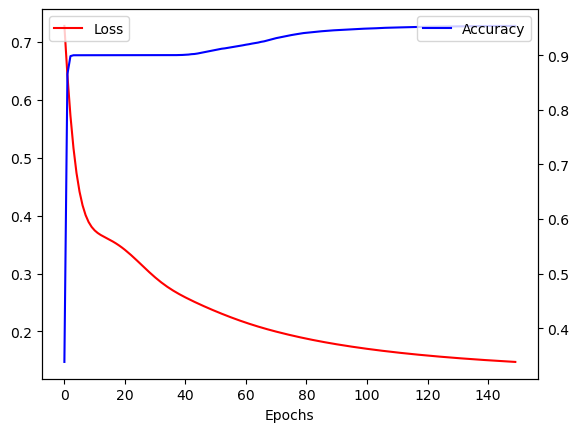

In [90]:
## 손실과 정확도 시각화
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()       # 축 정보를 갖고 있는 것이 ax1
ax1.plot(loss_list, label='Loss', color='red')

# x축 공유
ax2 = ax1.twinx()
ax2.plot(accuracy_list, label='Accuracy', color='blue')

ax1.set_xlabel('Epochs')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()